# Credit Risk Resampling Techniques

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd
from pathlib import Path
from collections import Counter

In [3]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import ClusterCentroids
from imblearn.combine import SMOTEENN
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import balanced_accuracy_score
from imblearn.metrics import classification_report_imbalanced

# define the feature set and the target column we would like to select from the data set

In [4]:
columns = [
    "loan_amnt", "int_rate", "installment", "home_ownership",
    "annual_inc", "verification_status", "issue_d", "loan_status",
    "pymnt_plan", "dti", "delinq_2yrs", "inq_last_6mths",
    "open_acc", "pub_rec", "revol_bal", "total_acc",
    "initial_list_status", "out_prncp", "out_prncp_inv", "total_pymnt",
    "total_pymnt_inv", "total_rec_prncp", "total_rec_int", "total_rec_late_fee",
    "recoveries", "collection_recovery_fee", "last_pymnt_amnt", "next_pymnt_d",
    "collections_12_mths_ex_med", "policy_code", "application_type", "acc_now_delinq",
    "tot_coll_amt", "tot_cur_bal", "open_acc_6m", "open_act_il",
    "open_il_12m", "open_il_24m", "mths_since_rcnt_il", "total_bal_il",
    "il_util", "open_rv_12m", "open_rv_24m", "max_bal_bc",
    "all_util", "total_rev_hi_lim", "inq_fi", "total_cu_tl",
    "inq_last_12m", "acc_open_past_24mths", "avg_cur_bal", "bc_open_to_buy",
    "bc_util", "chargeoff_within_12_mths", "delinq_amnt", "mo_sin_old_il_acct",
    "mo_sin_old_rev_tl_op", "mo_sin_rcnt_rev_tl_op", "mo_sin_rcnt_tl", "mort_acc",
    "mths_since_recent_bc", "mths_since_recent_inq", "num_accts_ever_120_pd", "num_actv_bc_tl",
    "num_actv_rev_tl", "num_bc_sats", "num_bc_tl", "num_il_tl",
    "num_op_rev_tl", "num_rev_accts", "num_rev_tl_bal_gt_0",
    "num_sats", "num_tl_120dpd_2m", "num_tl_30dpd", "num_tl_90g_dpd_24m",
    "num_tl_op_past_12m", "pct_tl_nvr_dlq", "percent_bc_gt_75", "pub_rec_bankruptcies",
    "tax_liens", "tot_hi_cred_lim", "total_bal_ex_mort", "total_bc_limit",
    "total_il_high_credit_limit", "hardship_flag", "debt_settlement_flag"
]

target = ["loan_status"]

# Read the CSV and Perform Basic Data Cleaning

In [5]:
# Load the data
file_path = Path('../Resources/LoanStats_2019Q1.csv.zip')
df = pd.read_csv(file_path, skiprows=1)[:-2]
df = df.loc[:, columns].copy()

# Drop the null columns where all values are null
df = df.dropna(axis='columns', how='all')

# Drop the null rows
df = df.dropna()

# Remove the `Issued` loan status
issued_mask = df['loan_status'] != 'Issued'
df = df.loc[issued_mask]

# convert interest rate to numerical
df['int_rate'] = df['int_rate'].str.replace('%', '')
df['int_rate'] = df['int_rate'].astype('float') / 100


# Convert the target column values to low_risk and high_risk based on their values
x = {'Current': 'low_risk'}   
df = df.replace(x)

x = dict.fromkeys(['Late (31-120 days)', 'Late (16-30 days)', 'Default', 'In Grace Period'], 'high_risk')    
df = df.replace(x)

df.reset_index(inplace=True, drop=True)

df.head()

,loan_amnt,int_rate,installment,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,dti,...,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,debt_settlement_flag
0,10500.0,0.1719,375.35,RENT,66000.0,Source Verified,Mar-2019,low_risk,n,27.24,...,85.7,100.0,0.0,0.0,65687.0,38199.0,2000.0,61987.0,N,N
1,25000.0,0.2000,929.09,MORTGAGE,105000.0,Verified,Mar-2019,low_risk,n,20.23,...,91.2,50.0,1.0,0.0,271427.0,60641.0,41200.0,49197.0,N,N
2,20000.0,0.2000,529.88,MORTGAGE,56000.0,Verified,Mar-2019,low_risk,n,24.26,...,66.7,50.0,0.0,0.0,60644.0,45684.0,7500.0,43144.0,N,N
3,10000.0,0.1640,353.55,RENT,92000.0,Verified,Mar-2019,low_risk,n,31.44,...,100.0,50.0,1.0,0.0,99506.0,68784.0,19700.0,76506.0,N,N
4,22000.0,0.1474,520.39,MORTGAGE,52000.0,Not Verified,Mar-2019,low_risk,n,18.76,...,100.0,0.0,0.0,0.0,219750.0,25919.0,27600.0,20000.0,N,N


# Assess the data types to identify the feture set that need to be encoded

In [6]:
# lets evaluate which columns have non-numeric values so we can encode those as part of pre-processing.
# As it is difficult to view 86 columns in 1 go, we will use exclude parameter in describe method 
#to select only those which are non-numeric that need to be addressed, including the dates and format of date columns
df.describe(exclude=[np.number])

,home_ownership,verification_status,issue_d,loan_status,pymnt_plan,initial_list_status,next_pymnt_d,application_type,hardship_flag,debt_settlement_flag
count,68817,68817,68817,68817,68817,68817,68817,68817,68817,68817
unique,4,3,3,2,1,2,2,2,1,1
top,MORTGAGE,Not Verified,Jan-2019,low_risk,n,w,May-2019,Individual,N,N
freq,36219,32895,31041,68470,68817,60292,42449,59206,68817,68817


In [7]:
#We got 10 columns that are not numeric (ints or floats) out of which we have two date columns. 
#let's check if the dates are of datetime data type
print(df.issue_d.dtype, df.next_pymnt_d.dtype )

object object


In [8]:
#the date columns issue_D and next_pymnt_d are of String data types. We will have to convert them to date or use the string 
#functions to map the month names to month numbers or we can use the get_dummies to encode the month into columns

# Encoding 
#### In this notebook we will use both Integer enconding using label encoder and binary encoding using get_dummies. 

### When to use which encoding technique: 

* if we have data set that has nominal data such as Nouns(city, bank, state etc.) or nominal data such as zip code, longitude/lattitude or any data with multiple digits (exclusing $ amounts/price etc.,) it is better to binary encode using get dummies. 

* In our data set we have month names(Jan, feb, Mar) in issue_d column and april, May in next paymnt date column, which can be considered as ordinal data. however the collection (of ordinal categories) is limited to 3 or 4, so we could just do integer encoding using label encoder and convert them to single digit representation. 

#### Another notebook (resampling_integer_encoded.ipynb) is created to demonstrate the same and evaluate the results between these two approaches of encoding. 

In [9]:
# Create the LabelEncoder instance
label_encoder = LabelEncoder()

# Encoding payment_plan column
label_encoder.fit(df["pymnt_plan"])
df["pymnt_plan"] = label_encoder.transform(df["pymnt_plan"])

# Encoding hardship_flag column
label_encoder.fit(df["hardship_flag"])
df["hardship_flag"] = label_encoder.transform(df["hardship_flag"])

# Encoding debt_settlement_flag column
label_encoder.fit(df["debt_settlement_flag"])
df["debt_settlement_flag"] = label_encoder.transform(df["debt_settlement_flag"])

### Binary Encoding Data using `get_dummies()`

In [10]:
# Perform a binary encoding on the 'home_ownership', 'issue_d', 'verification_status', 'initial_list_status',  'next_pymnt_d' and 'application_type' columns
df_encoded = pd.get_dummies(df, columns=['home_ownership', 'issue_d', 'verification_status', 'initial_list_status',  'next_pymnt_d', 'application_type'])
df_encoded.head()

,loan_amnt,int_rate,installment,annual_inc,loan_status,pymnt_plan,dti,delinq_2yrs,inq_last_6mths,open_acc,...,issue_d_Mar-2019,verification_status_Not Verified,verification_status_Source Verified,verification_status_Verified,initial_list_status_f,initial_list_status_w,next_pymnt_d_Apr-2019,next_pymnt_d_May-2019,application_type_Individual,application_type_Joint App
0,10500.0,0.1719,375.35,66000.0,low_risk,0,27.24,0.0,0.0,8.0,...,1,0,1,0,0,1,0,1,1,0
1,25000.0,0.2000,929.09,105000.0,low_risk,0,20.23,0.0,0.0,17.0,...,1,0,0,1,0,1,0,1,1,0
2,20000.0,0.2000,529.88,56000.0,low_risk,0,24.26,0.0,0.0,8.0,...,1,0,0,1,0,1,0,1,1,0
3,10000.0,0.1640,353.55,92000.0,low_risk,0,31.44,0.0,1.0,10.0,...,1,0,0,1,0,1,0,1,1,0
4,22000.0,0.1474,520.39,52000.0,low_risk,0,18.76,0.0,1.0,14.0,...,1,1,0,0,0,1,0,1,1,0


In [11]:
# let's check if we have the final data set in the right format. given that the date columns also converted to numeric,
# we will have all columns in number format either ints or floats. when we use exclude parameter we should get only one 
# column (loan_status wich is our target class.
df_encoded.describe(exclude=[np.number])

,loan_status
count,68817
unique,2
top,low_risk
freq,68470


In [12]:
# Saving the encoded data set for use in credit_risk_ensemble.ipynb. We will directly use this clean and encoded data set 
#while modelinng ensemble classifiers 

file_path = Path('../Resources/credit_risk_encoded.csv')
df_encoded.to_csv(file_path, index=False)

# Split the Data into Training and Testing

In [13]:
# Create our features
X = df_encoded.drop('loan_status', axis=1)

# Create our target
y = df_encoded['loan_status']

In [14]:
X.describe()

,loan_amnt,int_rate,installment,annual_inc,pymnt_plan,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,...,issue_d_Mar-2019,verification_status_Not Verified,verification_status_Source Verified,verification_status_Verified,initial_list_status_f,initial_list_status_w,next_pymnt_d_Apr-2019,next_pymnt_d_May-2019,application_type_Individual,application_type_Joint App
count,68817.000000,68817.000000,68817.000000,6.881700e+04,68817.0,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,...,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000
mean,16677.594562,0.127718,480.652863,8.821371e+04,0.0,21.778153,0.217766,0.497697,12.587340,0.126030,...,0.177238,0.478007,0.373992,0.148001,0.123879,0.876121,0.383161,0.616839,0.860340,0.139660
std,10277.348590,0.048130,288.062432,1.155800e+05,0.0,20.199244,0.718367,0.758122,6.022869,0.336797,...,0.381873,0.499520,0.483865,0.355104,0.329446,0.329446,0.486161,0.486161,0.346637,0.346637
min,1000.000000,0.060000,30.890000,4.000000e+01,0.0,0.000000,0.000000,0.000000,2.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,9000.000000,0.088100,265.730000,5.000000e+04,0.0,13.890000,0.000000,0.000000,8.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000
50%,15000.000000,0.118000,404.560000,7.300000e+04,0.0,19.760000,0.000000,0.000000,11.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000
75%,24000.000000,0.155700,648.100000,1.040000e+05,0.0,26.660000,0.000000,1.000000,16.000000,0.000000,...,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000
max,40000.000000,0.308400,1676.230000,8.797500e+06,0.0,999.000000,18.000000,5.000000,72.000000,4.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [15]:
# Check the balance of our target values
y.value_counts()

low_risk     68470
high_risk      347
Name: loan_status, dtype: int64

In [16]:
# Split the X and y into X_train, X_test, y_train, y_test
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

## Data Pre-Processing

Scale the training and testing data using the `StandardScaler` from `sklearn`. Remember that when scaling the data, We only scale the features data (`X_train` and `X_testing`).

In [17]:
# Create the StandardScaler instance
scaler = StandardScaler()

In [18]:
# Fit the Standard Scaler with the training data
std_scaler = scaler.fit(X_train)

In [19]:
# Scale the training and testing data
X_train_scaled = std_scaler.transform(X_train)
X_test_scaled = std_scaler.transform(X_test)

# Oversampling

In this section, We will compare two oversampling algorithms to determine which algorithm results in the best performance. We will oversample the data using the naive random oversampling algorithm and the SMOTE algorithm. For each algorithm, be sure to complete the folliowing steps:

1. View the count of the target classes using `Counter` from the collections library. 
3. Use the resampled data to train a logistic regression model.
3. Calculate the balanced accuracy score from sklearn.metrics.
4. Print the confusion matrix from sklearn.metrics.
5. Generate a classication report using the `imbalanced_classification_report` from imbalanced-learn.

Note: Use a random state of 1 for each sampling algorithm to ensure consistency between tests

### Naive Random Oversampling

In [20]:
# Resample the training data with the RandomOversampler
ros = RandomOverSampler(random_state=1)
X_resampled, y_resampled = ros.fit_resample(X_train_scaled, y_train)
Counter(y_resampled)

Counter({'low_risk': 51366, 'high_risk': 51366})

In [21]:
# Train the Logistic Regression model using RandomOversampler resampled data
lr_model_ros = LogisticRegression(solver='lbfgs', random_state=1)
lr_model_ros.fit(X_resampled, y_resampled)
y_pred_ros = lr_model_ros.predict(X_test_scaled)

In [22]:
# Calculated the balanced accuracy score
blncd_acc_score_ros = balanced_accuracy_score(y_test, y_pred_ros)
blncd_acc_score_ros

0.8322545128694347

In [23]:
# Display the confusion matrix
ros_cmatrix=confusion_matrix(y_test, y_pred_ros)
pd.DataFrame(ros_cmatrix, columns=['Predicted_low', 'predicted_high'], index=['Actual_low', 'Actual_high'])

,Predicted_low,predicted_high
Actual_low,83,18
Actual_high,2690,14414


In [24]:
# Print the imbalanced classification report
imb_clf_report_ros = classification_report_imbalanced(y_test, y_pred_ros)
print(imb_clf_report_ros)

                   pre       rec       spe        f1       geo       iba       sup

  high_risk       0.03      0.82      0.84      0.06      0.83      0.69       101
   low_risk       1.00      0.84      0.82      0.91      0.83      0.69     17104

avg / total       0.99      0.84      0.82      0.91      0.83      0.69     17205



### SMOTE Oversampling

In [25]:
# Resample the training data with SMOTE
X_resampled, y_resampled = SMOTE(random_state=1, sampling_strategy=1.0).fit_resample(X_train_scaled, y_train)
Counter(y_resampled)

Counter({'low_risk': 51366, 'high_risk': 51366})

In [26]:
# Train the Logistic Regression model using SMOTE resampled data
lr_model_smt = LogisticRegression(solver='lbfgs', random_state=1)
lr_model_smt.fit(X_resampled, y_resampled)
y_pred_smt = lr_model_smt.predict(X_test_scaled)

In [27]:
# Calculated the balanced accuracy score
blncd_acc_score_smt = balanced_accuracy_score(y_test, y_pred_smt)
blncd_acc_score_smt

0.8388510243681058

In [28]:
# Display the confusion matrix
smt_cmatrix = confusion_matrix(y_test, y_pred_smt)
pd.DataFrame(smt_cmatrix, columns=['Predicted_low', 'predicted_high'], index=['Actual_low', 'Actual_high'])

,Predicted_low,predicted_high
Actual_low,82,19
Actual_high,2295,14809


In [29]:
# Print the imbalanced classification report
imb_clf_report_smt = classification_report_imbalanced(y_test, y_pred_smt)
print(imb_clf_report_smt)

                   pre       rec       spe        f1       geo       iba       sup

  high_risk       0.03      0.81      0.87      0.07      0.84      0.70       101
   low_risk       1.00      0.87      0.81      0.93      0.84      0.71     17104

avg / total       0.99      0.87      0.81      0.92      0.84      0.71     17205



# Undersampling

In this section, we will test an undersampling algorithms to determine which algorithm results in the best performance compared to the oversampling algorithms above. we will undersample the data using the Cluster Centroids algorithm and complete the folliowing steps:

1. View the count of the target classes using `Counter` from the collections library. 
3. Use the resampled data to train a logistic regression model.
3. Calculate the balanced accuracy score from sklearn.metrics.
4. Print the confusion matrix from sklearn.metrics.
5. Generate a classication report using the `imbalanced_classification_report` from imbalanced-learn.

In [30]:
# Resample the data using the ClusterCentroids resampler
X_resampled, y_resampled = ClusterCentroids(random_state=1, sampling_strategy=1.0).fit_resample(X_train_scaled, y_train)
Counter(y_resampled)

Counter({'high_risk': 246, 'low_risk': 246})

In [31]:
# Train the Logistic Regression model using ClusterCentroid resampled data
lr_model_cc = LogisticRegression(solver='lbfgs', random_state=1)
lr_model_cc.fit(X_resampled, y_resampled)
y_pred_cc = lr_model_cc.predict(X_test_scaled)

In [32]:
# Calculated the balanced accuracy score
blncd_acc_score_cc = balanced_accuracy_score(y_test, y_pred_cc)
blncd_acc_score_cc

0.8215575767118339

In [33]:
# Display the confusion matrix
cc_cmatrix = confusion_matrix(y_test, y_pred_cc)
pd.DataFrame(cc_cmatrix, columns=['Predicted_low', 'predicted_high'], index=['Actual_low', 'Actual_high'])

,Predicted_low,predicted_high
Actual_low,89,12
Actual_high,4072,13032


In [34]:
# Print the imbalanced classification report
imb_clf_report_cc = classification_report_imbalanced(y_test, y_pred_cc)
print(imb_clf_report_cc)

                   pre       rec       spe        f1       geo       iba       sup

  high_risk       0.02      0.88      0.76      0.04      0.82      0.68       101
   low_risk       1.00      0.76      0.88      0.86      0.82      0.66     17104

avg / total       0.99      0.76      0.88      0.86      0.82      0.66     17205



# Combination (Over and Under) Sampling

In this section, We will test a combination over- and under-sampling algorithm to determine if the algorithm results in the best performance compared to the other sampling algorithms above. We will resample the data using the SMOTEENN algorithm and complete the folliowing steps:

1. View the count of the target classes using `Counter` from the collections library. 
3. Use the resampled data to train a logistic regression model.
3. Calculate the balanced accuracy score from sklearn.metrics.
4. Print the confusion matrix from sklearn.metrics.
5. Generate a classication report using the `imbalanced_classification_report` from imbalanced-learn.

Note: Use a random state of 1 for each sampling algorithm to ensure consistency between tests

In [36]:
# Resample the training data with SMOTEENN
X_resampled, y_resampled = SMOTEENN(random_state=1).fit_resample(X_train_scaled, y_train)
Counter(y_resampled)

Counter({'high_risk': 51366, 'low_risk': 47635})

In [37]:
# Train the Logistic Regression model using SMOTEENN resampled data
lr_model_smtenn = LogisticRegression(solver='lbfgs', random_state=1)
lr_model_smtenn.fit(X_resampled, y_resampled)
y_pred_smtenn = lr_model_smtenn.predict(X_test_scaled)

In [38]:
# Calculated the balanced accuracy score
blncd_acc_score_smtenn = balanced_accuracy_score(y_test, y_pred_smtenn)
blncd_acc_score_smtenn

0.8388319216626994

In [39]:
# Display the confusion matrix
smenn_cmatrix = confusion_matrix(y_test, y_pred_smtenn)
pd.DataFrame(smenn_cmatrix, columns=['Predicted_low', 'predicted_high'], index=['Actual_low', 'Actual_high'])

,Predicted_low,predicted_high
Actual_low,83,18
Actual_high,2465,14639


In [40]:
# Print the imbalanced classification report
imb_clf_report_smtenn = classification_report_imbalanced(y_test, y_pred_smtenn)
print(imb_clf_report_smtenn)

                   pre       rec       spe        f1       geo       iba       sup

  high_risk       0.03      0.82      0.86      0.06      0.84      0.70       101
   low_risk       1.00      0.86      0.82      0.92      0.84      0.71     17104

avg / total       0.99      0.86      0.82      0.92      0.84      0.71     17205



# Evaluation

From the oversample/undersample techniques used above, let's answer the following quesitons:
* Which model had the best balanced accuracy score?
* Which model had the best recall score?
* Which model had the best geometric mean score?

### Before we answer the questions, Wouldnt it be nice to graphically compare the models taking a snapshot of all the metrics? let the plot answer the questions!
We will define a function that plots a comparison of the metrics and answer the questions.

In [41]:
def cmatrix_plot(matrix, bac_score):
    """function to plot classification metrics and balanced accuracy score"""
    
    cmatrix_df = pd.DataFrame(columns=['model', 'TN', 'FP', 'FN', 'TP'])
    for k, v in matrix.items():
        v= v.ravel()
        cmatrix_df = cmatrix_df.append({'model': k, 'TN': int(v[0]), 'FP': int(v[1]), 'FN': int(v[2]), 'TP': int(v[3])}, ignore_index=True)

    cmatrix_df.set_index('model', inplace=True)
    cmatrix_df['bac'] =  [round(x,2) for x in bac_score]
    cmatrix_df['pre'] =  cmatrix_df.apply(lambda row: round(row.TP/(row.FP+row.TP), 2), axis=1)
    cmatrix_df['rec'] =  cmatrix_df.apply(lambda row: round(row.TP/(row.FN+row.TP), 2), axis=1)
    cmatrix_df['spe'] =  cmatrix_df.apply(lambda row: round(row.TN/(row.TN+row.FP), 2), axis=1)
    cmatrix_df['geo'] =  cmatrix_df.apply(lambda row: round((row.rec + row.spe)/2, 2), axis=1)
    cmatrix_df = cmatrix_df.drop(['TN', 'FN', 'FP', 'TP'], axis=1)
    metrics_plot= cmatrix_df.plot(kind='bar', use_index=False, grid=True, figsize=(10, 5), label=False, 
                  position=1, table=True, rot=15, title='Classification Metrics using Integer& binary Encoding')
    
    return metrics_plot


Bad key "text.kerning_factor" on line 4 in
C:\Users\TinkerBell\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


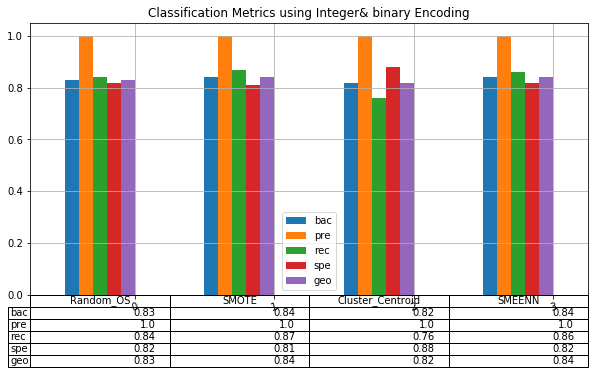

In [42]:
cmatrix={'Random_OS': ros_cmatrix, 'SMOTE': smt_cmatrix, 'Cluster_Centroid': cc_cmatrix, 'SMEENN': smenn_cmatrix}
data = [blncd_acc_score_ros, blncd_acc_score_smt, blncd_acc_score_cc, blncd_acc_score_smtenn]
cmatrix_plot(cmatrix, data)

### Let's answer the questions:

1. Which model has best balanced accuracy score
* BAC score is more or less the same across the models, with mrginal difference. BAC scores from SMOTEENN and SMOTE models are equal at 0.838, cluster centroid model gave a BAC score of 0.821 and RandomOverSampling has  BAC score of 0.832. 
* Best BAC score is from SMOTE and SMOTEEN models. 

2. Which model had the best recall score?
* SMOTE model produced best Recall at 0.87. 
* SMOTEENN score is tad bit lower at 0.86. Cluster centroid produced lowest Recall at 0.76

3. Which model had the best geometric mean score?
* Both SMOTE and SMOTEENN models have same geo metric mean of 0.84.
* Cluster centroid model has the lowest geo mean of 0.82

## Conclusion:
SMOTE and SMOTEENN sampling models are better for our Credit Risk modeling compared to Random OVersampling  or Cluster centroid. 